In [46]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, DBSCAN, AgglomerativeClustering, estimate_bandwidth
import seaborn as sns; sns.set()
import numpy as np
from itertools import cycle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ecopy as ep
from sklearn import metrics

In [9]:
df = pd.read_csv("temp_data.csv", sep=";")
x = df.iloc[1:, 1:].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['names'] = df.track_name

dunes = df.iloc[1:, 1:].values**2
dunes_T = ep.transform(dunes, 'wisconsin')
dunes_D = ep.distance(dunes_T, 'bray')
dunesMDS = ep.MDS(dunes_D)
names = df['track_name'].values
massive = dunesMDS.scores

colors = cycle('bgrcmy')

c:\users\николай\appdata\local\programs\python\python37-32\lib\site-packages\ecopy\ordination\pcoa.py:138: RuntimeWarning: invalid value encountered in sqrt
  self.U = np.round(self.U.dot(np.diag(np.sqrt(self.evals))), 4)


Finished at iteration 2. Stress = 0.25585132299193775
Finished at iteration 33. Stress = 0.27061609139821186
Finished at iteration 40. Stress = 0.2423012408523739
Finished at iteration 24. Stress = 0.29943812911227163
Finished at iteration 72. Stress = 0.27391477600896486
Finished at iteration 42. Stress = 0.23934877390862092
Finished at iteration 8. Stress = 0.4107448635464495
Finished at iteration 9. Stress = 0.41031516009770214
Finished at iteration 20. Stress = 0.2832664700560678
Finished at iteration 9. Stress = 0.4099354572479352
Finished at iteration 42. Stress = 0.2663951196049336
Finished at iteration 34. Stress = 0.2563711310585212
Finished at iteration 33. Stress = 0.3124425597059238
Finished at iteration 26. Stress = 0.24390415867373913
Finished at iteration 41. Stress = 0.27462611788788155
Finished at iteration 41. Stress = 0.2464758260983948
Finished at iteration 59. Stress = 0.22767409565633684
Finished at iteration 22. Stress = 0.3385398859796912
Finished at iteration 4

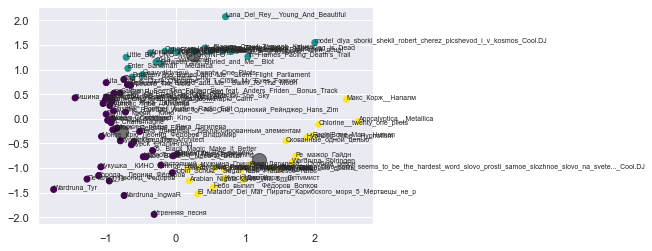

In [10]:
### K-MEANS

kmeans = KMeans(n_clusters = 3).fit(massive)
y_kmeans = kmeans.predict(massive)
plt.scatter(massive[:, 0], massive[:, 1], c=y_kmeans, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

for i in enumerate(names):
    plt.text(massive[i[0] - 1][0], massive[i[0] - 1][1], names[i[0]], size="xx-small")

Text(0.5, 1.0, 'Estimated number of clusters: 7')

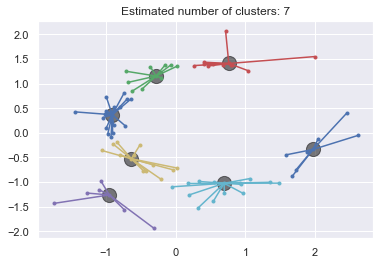

In [11]:
### AFFINITY POROP

af = AffinityPropagation().fit(massive)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = massive[cluster_centers_indices[k]]
    plt.plot(massive[class_members, 0], massive[class_members, 1], col + '.')
    plt.scatter(cluster_center[0], cluster_center[1], c='black', s=200, alpha=0.5)
    for i in massive[class_members]:
        plt.plot([cluster_center[0], i[0]], [cluster_center[1], i[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Text(0.5, 1.0, 'Estimated number of clusters: 2')

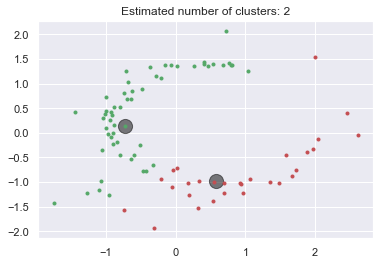

In [12]:
### MEANSHIFT

ms = MeanShift().fit(massive)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(massive[class_members, 0], massive[class_members, 1], col + '.')
    plt.scatter(cluster_center[0], cluster_center[1], c='black', s=200, alpha=0.5)

plt.title('Estimated number of clusters: %d' % n_clusters_)

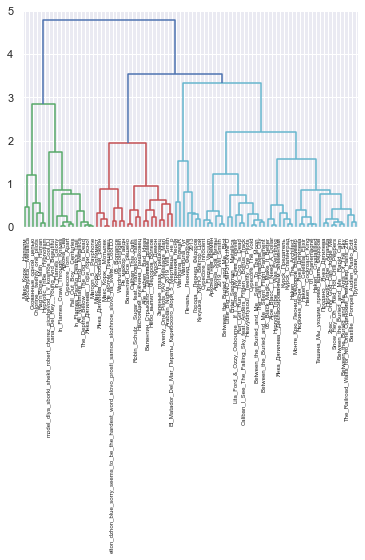

In [67]:
### HIERARCHY

mergings = linkage(massive, method='complete')
dendrogram(mergings, labels=names)
plt.show()

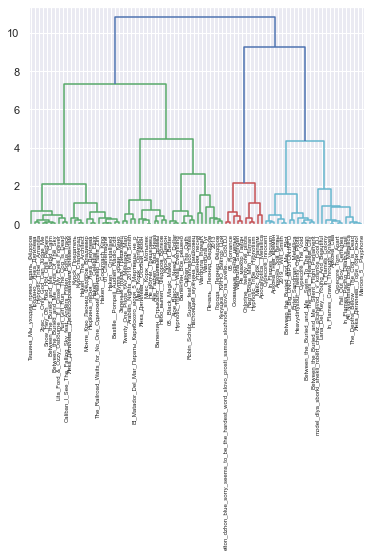

In [68]:
mergings = linkage(massive, method='ward')
dendrogram(mergings, labels=names)
plt.show()

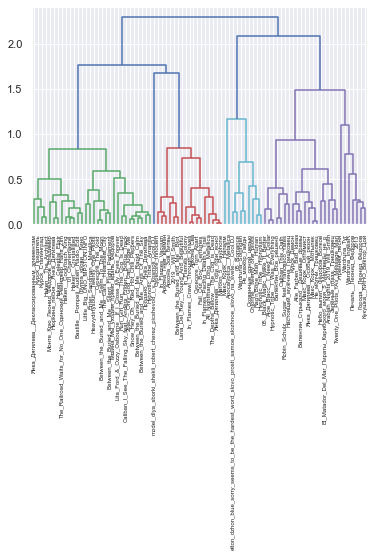

In [69]:
mergings = linkage(massive, method='average')
dendrogram(mergings, labels=names)
plt.show()

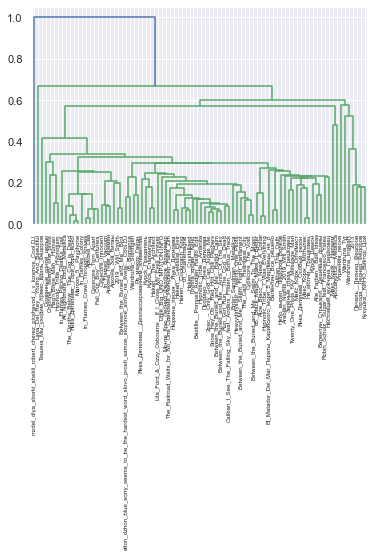

In [70]:
mergings = linkage(massive, method='single')
dendrogram(mergings, labels=names)
plt.show()

Text(0.5, 1.0, 'Estimated number of clusters: 2')

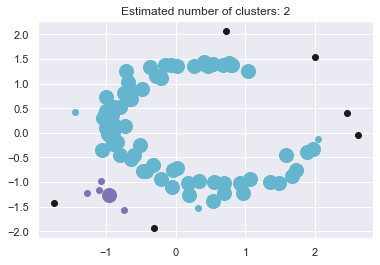

In [14]:
### DBSCAN

db = DBSCAN().fit(massive)
labels = db.labels_
samples = np.zeros_like(labels, dtype=bool)
samples[db.core_sample_indices_] = True

unique_labels = set(labels)
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'

    class_members = labels == k

    xy = massive[class_members & samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=col, markersize=14)

    xy = massive[class_members & ~samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=col, markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

In [24]:
with open('principle.csv', encoding='utf-8') as f:
    numbers = []
    for lines in f:
        numbers.append(lines.split()[-1])
numbers.remove(numbers[0])
target = [int(i) for i in numbers]

x, y = massive, target

algorithms = []
algorithms.append(KMeans(n_clusters = 3))
algorithms.append(AffinityPropagation())
algorithms.append(DBSCAN())
algorithms.append(MeanShift())
algorithms.append(AgglomerativeClustering())

data = []
for algo in algorithms:
    algo.fit(x)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(x, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=['K-means', 'Affinity',
                              'DBSCAN', 'MeanShift', 'Agglomerative'])
print(results)

                    ARI       AMI  Homogenity  Completeness  V-measure  \
K-means        0.012342 -0.007554    0.090285      0.194331   0.123290   
Affinity       0.006053  0.007215    0.235334      0.283825   0.257315   
DBSCAN         0.004446 -0.027480    0.046347      0.221399   0.076648   
MeanShift      0.037478  0.026763    0.065097      0.230854   0.101556   
Agglomerative -0.006175 -0.023199    0.036173      0.121718   0.055771   

               Silhouette  
K-means          0.467728  
Affinity         0.461898  
DBSCAN           0.071970  
MeanShift        0.427336  
Agglomerative    0.364146  


In [23]:
data = []
for i in range(2, 8):
    km = KMeans(n_clusters = i).fit(massive)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, km.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, km.labels_),
        'Homogenity': metrics.homogeneity_score(y, km.labels_),
        'Completeness': metrics.completeness_score(y, km.labels_),
        'V-measure': metrics.v_measure_score(y, km.labels_),
        'Silhouette': metrics.silhouette_score(x, km.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=list(range(2, 8)))
print(results)

        ARI       AMI  Homogenity  Completeness  V-measure  Silhouette
2 -0.009006 -0.014338    0.041683      0.137943   0.064020    0.425358
3  0.012342 -0.007554    0.090285      0.194331   0.123290    0.467728
4 -0.002720 -0.017617    0.124530      0.208435   0.155911    0.482585
5  0.012854  0.015204    0.181165      0.262498   0.214376    0.474944
6 -0.011036 -0.036117    0.179445      0.231953   0.202348    0.457772
7 -0.010635 -0.015641    0.220323      0.264917   0.240571    0.471303


In [28]:
data = []
for i in range(-25, -125, -25):
    km = AffinityPropagation(preference = i).fit(massive)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, km.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, km.labels_),
        'Homogenity': metrics.homogeneity_score(y, km.labels_),
        'Completeness': metrics.completeness_score(y, km.labels_),
        'V-measure': metrics.v_measure_score(y, km.labels_),
        'Silhouette': metrics.silhouette_score(x, km.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=list(range(-25, -125, -25)))
print(results)

           ARI       AMI  Homogenity  Completeness  V-measure  Silhouette
-25  -0.002720 -0.033124    0.114017      0.191063   0.142811    0.463197
-50   0.040060  0.016976    0.105653      0.227825   0.144360    0.470548
-75  -0.008211 -0.013346    0.042304      0.139711   0.064943    0.423004
-100 -0.007814 -0.008241    0.045308      0.150374   0.069635    0.396993


In [41]:
data = []
for i in np.arange(0.1, 1, 0.1):
    km = DBSCAN(eps = i).fit(massive)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, km.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, km.labels_),
        'Homogenity': metrics.homogeneity_score(y, km.labels_),
        'Completeness': metrics.completeness_score(y, km.labels_),
        'V-measure': metrics.v_measure_score(y, km.labels_),
        'Silhouette': metrics.silhouette_score(x, km.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=list(np.arange(0.1, 1, 0.1)))
print(results)

          ARI       AMI  Homogenity  Completeness  V-measure  Silhouette
0.1 -0.001007  0.009586    0.034429      0.348699   0.062671   -0.123546
0.2 -0.030727  0.016414    0.094641      0.245575   0.136628    0.198433
0.3  0.037815  0.015429    0.163591      0.268292   0.203250    0.181492
0.4 -0.000187 -0.026436    0.057059      0.196099   0.088397    0.123133
0.5  0.004446 -0.027480    0.046347      0.221399   0.076648    0.071970
0.6  0.013071  0.008024    0.030781      0.367460   0.056804    0.293758
0.7  0.003196  0.000140    0.012557      0.444378   0.024424    0.299451
0.8  0.003196  0.000140    0.012557      0.444378   0.024424    0.299451
0.9  0.003196  0.000140    0.012557      0.444378   0.024424    0.299451


In [43]:
data = []
for i in ['ward', 'complete', 'average', 'single']:
    km = AgglomerativeClustering(linkage = i).fit(massive)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, km.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, km.labels_),
        'Homogenity': metrics.homogeneity_score(y, km.labels_),
        'Completeness': metrics.completeness_score(y, km.labels_),
        'V-measure': metrics.v_measure_score(y, km.labels_),
        'Silhouette': metrics.silhouette_score(x, km.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=['ward', 'complete', 'average', 'single'])
print(results)

               ARI       AMI  Homogenity  Completeness  V-measure  Silhouette
ward     -0.006175 -0.023199    0.036173      0.121718   0.055771    0.364146
complete -0.000627 -0.017995    0.035230      0.154965   0.057409    0.370008
average   0.010705 -0.003958    0.047765      0.159852   0.073552    0.428986
single    0.003196  0.000140    0.012557      0.444378   0.024424    0.299451


In [66]:
data = []
for i in [False, True]:
    km = MeanShift(bin_seeding=i).fit(massive)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, km.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, km.labels_),
        'Homogenity': metrics.homogeneity_score(y, km.labels_),
        'Completeness': metrics.completeness_score(y, km.labels_),
        'V-measure': metrics.v_measure_score(y, km.labels_),
        'Silhouette': metrics.silhouette_score(x, km.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure',
                                           'Silhouette'],
                       index=['false', 'true'])
print(results)

            ARI       AMI  Homogenity  Completeness  V-measure  Silhouette
false  0.037478  0.026763    0.065097      0.230854   0.101556    0.427336
true   0.037478  0.026763    0.065097      0.230854   0.101556    0.427336
